# Hyper parameter tuning with Keras

- I am feeling bit lazy to actually split the data into test and train - in a productive scenario always always do that.

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV

from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

from keras.optimizers import SGD
from keras.constraints import maxnorm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('housing.csv', header=1)

X = data.iloc[:,:13]
X_scaled = StandardScaler().fit_transform(X)
print(X_scaled[0:2])

y = data.iloc[:,13:14]
print(y[0:2])

num_features = X.shape[1]

[[-0.41783001 -0.48671582 -0.59632231 -0.27288841 -0.73983089  0.19493376
   0.36657124  0.55689727 -0.86980108 -0.98810692 -0.30632705  0.44157346
  -0.49464713]
 [-0.41783233 -0.48671582 -0.59632231 -0.27288841 -0.73983089  1.2824812
  -0.26579018  0.55689727 -0.86980108 -0.98810692 -0.30632705  0.39698405
  -1.21104804]]
     24
0  21.6
1  34.7


C:\MachineLearning\anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\MachineLearning\anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [3]:
# setup seed for randomness
seed = 7
np.random.seed(seed)

### Bit About Learning Rate
    - Adapting the learning rate for your SGD optimization procedure can increase performance and reducing the training time.
    - Simplest and most used approach for learning rates is to reduce it over time. At the start of training, high learning rate allows for quicker learning but as training progresses learning rate is reduced to allow for gentler descent. There are two ways in which this can be done
        - Decrease the learning rate gradually based on the epochs
        - Decrease the learning rate using puntucate large drops at specific epochs
        
### Bit About Dropout Regulazation for Neural / Deep Nets
    - Dropout is a technique where randomly selected neurons are ignored during the training process. They are dropped out randomly. This means that their contribution to the activation of the downstream neuron is temporarily removed on the forward pass any weight updates are not applied to the neuron on the backward pass.
    - The effect of this is that the network becomes less sensitive to the specific weights of any neuron. This is turn leads in a network that is capable of better generalization is less likely to overfit
    
### Checkpointing Neural Network Models
    - Training of Neural networks can be a length process, potentially running into hours and days !
    - Checkpointing is one approach which allows us to periodically checkpoint our mode (i.e. dump the calculated weights of each neuron to a file).
    These saved weights can be loaded in model at a later stage to train the model from where it left earlier.
    - A good approach is to checkpoint the weights when any metric improves, for e.g. as the val_acc (accuracy on validatation data) improves we can checkpoint the model

In [74]:
import math

# Setting learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.05
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

callbacks_list = [lrate]

In [71]:
# Define Deep Net model
def create_model(epochs=20, init_mode='normal', activation='relu', dropout_rate=0.2, weight_constraint=0, neurons=13):
    nnModel = Sequential()
    nnModel.add(Dense(neurons, activation=activation, kernel_initializer=init_mode, input_dim=num_features, kernel_constraint=maxnorm(weight_constraint)))
    nnModel.add(Dropout(dropout_rate))
    nnModel.add(Dense(neurons, activation=activation, kernel_initializer=init_mode))
    nnModel.add(Dense(1)) # no activation function required at output layer since it's a regression problem
    nnModel.compile(optimizer='adam', loss='mse', metrics=['mae'])
    nnModel.summary()
    return nnModel

In [23]:
# Define hyperparameters
p_epochs=[20,40,80]
p_batch_size=[10,20]
p_init_mode=['normal']
p_activation=['relu','tanh']
p_dropout_rate=[0.2,0.3]
p_weight_constraints=[1,3]
p_neurons=[36,48,72]

params = dict(epochs=p_epochs,
             activation=p_activation,
             init_mode=p_init_mode,
             batch_size=p_batch_size,
             dropout_rate=p_dropout_rate,
             weight_constraint=p_weight_constraints,
             neurons=p_neurons)

In [24]:
# initialize regressor and fit the data
hp_regressor = KerasRegressor(build_fn=create_model, validation_split=0.2)
gridCV = GridSearchCV(hp_regressor, param_grid=params, n_jobs=-1, cv=4, error_score='raise', verbose=1)
results = gridCV.fit(X_scaled, y, callbacks=callbacks_list)

Fitting 4 folds for each of 144 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 10.7min finished
C:\MachineLearning\anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 72)                1008      
_________________________________________________________________
dropout_4 (Dropout)          (None, 72)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 72)                5256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 73        
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________
Train on 404 samples, validate on 101 samples
Epoch 1/80
404/404 [==============================] - 0s 1ms/step - loss: 212.2725 - mean_absolute_error: 10.7228 - val_loss: 34.8803 - val_mean_absolute_error: 4.3415
Epoch 2/80
404/404 [==============================] - 0s 7

404/404 [==============================] - 0s 72us/step - loss: 10.6686 - mean_absolute_error: 2.4401 - val_loss: 18.5599 - val_mean_absolute_error: 3.2906
Epoch 45/80
404/404 [==============================] - 0s 72us/step - loss: 11.8308 - mean_absolute_error: 2.5386 - val_loss: 18.5596 - val_mean_absolute_error: 3.2906
Epoch 46/80
404/404 [==============================] - 0s 69us/step - loss: 9.7445 - mean_absolute_error: 2.2534 - val_loss: 18.5592 - val_mean_absolute_error: 3.2905
Epoch 47/80
404/404 [==============================] - 0s 69us/step - loss: 12.0392 - mean_absolute_error: 2.5269 - val_loss: 18.5589 - val_mean_absolute_error: 3.2905
Epoch 48/80
404/404 [==============================] - 0s 72us/step - loss: 11.7782 - mean_absolute_error: 2.5010 - val_loss: 18.5586 - val_mean_absolute_error: 3.2905
Epoch 49/80
404/404 [==============================] - 0s 69us/step - loss: 12.5905 - mean_absolute_error: 2.5222 - val_loss: 18.5584 - val_mean_absolute_error: 3.2904
Epoch

In [26]:
# summarize results
print ('Best score is %s with params %s'%(results.best_score_, results.best_params_))
means = results.cv_results_['mean_test_score']
stds = results.cv_results_['std_test_score']
params = results.cv_results_['params']

Best score is -20.35195713279271 with params {'activation': 'relu', 'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 80, 'init_mode': 'normal', 'neurons': 72, 'weight_constraint': 3}


## Re-Train Using Best Parameters
    - Once the model is trained and best hyperparameters are known we can tun the model using the best parameters and save it for predictions

In [72]:
# final model configuration
def create_final_model():
    nnModel = Sequential()
    nnModel.add(Dense(72, activation='relu', kernel_initializer='normal', input_dim=num_features, kernel_constraint=maxnorm(3)))
    nnModel.add(Dropout(0.2))
    nnModel.add(Dense(72, activation='relu'))
    nnModel.add(Dense(1)) # no activation function required at output layer since it's a regression problem
    nnModel.compile(optimizer='adam', loss='mse', metrics=['mae'])
    nnModel.summary()
    return nnModel

In [75]:
# model checkpoint params
filepath = 'weights_best.json'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [lrate, checkpoint]

# initialize regressor and fit the data
final_regressor = KerasRegressor(build_fn=create_final_model, validation_split=0.3, epochs=80, batch_size=10)
history = final_regressor.fit(X_scaled, y, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 72)                1008      
_________________________________________________________________
dropout_20 (Dropout)         (None, 72)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 72)                5256      
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 73        
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________
Train on 353 samples, validate on 152 samples
Epoch 1/80
353/353 [==============================] - 2s 5ms/step - loss: 195.6469 - mean_absolute_error: 10.3465 - val_loss: 115.2477 - val_mean_absolute_error: 8.1166
Epoch 2/80
353/353 [==============================] - 0s 

353/353 [==============================] - 0s 119us/step - loss: 7.9738 - mean_absolute_error: 2.1511 - val_loss: 56.9015 - val_mean_absolute_error: 5.4580
Epoch 45/80
353/353 [==============================] - 0s 113us/step - loss: 8.6351 - mean_absolute_error: 2.1860 - val_loss: 56.9011 - val_mean_absolute_error: 5.4580
Epoch 46/80
353/353 [==============================] - 0s 113us/step - loss: 8.4816 - mean_absolute_error: 2.2624 - val_loss: 56.9007 - val_mean_absolute_error: 5.4580
Epoch 47/80
353/353 [==============================] - 0s 119us/step - loss: 7.6260 - mean_absolute_error: 2.1293 - val_loss: 56.9001 - val_mean_absolute_error: 5.4579
Epoch 48/80
353/353 [==============================] - 0s 113us/step - loss: 8.2462 - mean_absolute_error: 2.1556 - val_loss: 56.8999 - val_mean_absolute_error: 5.4579
Epoch 49/80
353/353 [==============================] - 0s 116us/step - loss: 7.3753 - mean_absolute_error: 2.0097 - val_loss: 56.8994 - val_mean_absolute_error: 5.4579
Epoc

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'lr'])


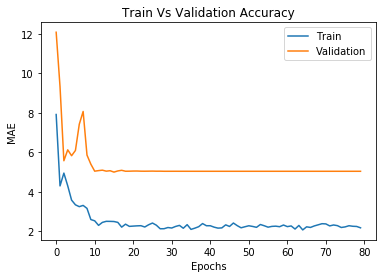

In [62]:
## Visualizing Model Accuracy on Training & Validation data
print (history.history.keys())
trainAccHistory = history.history['mean_absolute_error']
validationAccHistory = history.history['val_mean_absolute_error']

plt.plot(trainAccHistory)
plt.plot(validationAccHistory)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Train Vs Validation Accuracy')
plt.legend(['Train','Validation'])
plt.show()

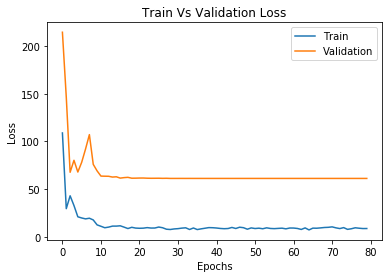

In [63]:
## Visualizing Loss on Training & Validation data
trainLossHistory = history.history['loss']
validationLossHistory = history.history['val_loss']

plt.plot(trainLossHistory)
plt.plot(validationLossHistory)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Vs Validation Loss')
plt.legend(['Train','Validation'])
plt.show()